In [2]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import execute, Aer
# from qc_grader import prepare_ex3, grade_ex3
import numpy as np
from heapq import nlargest


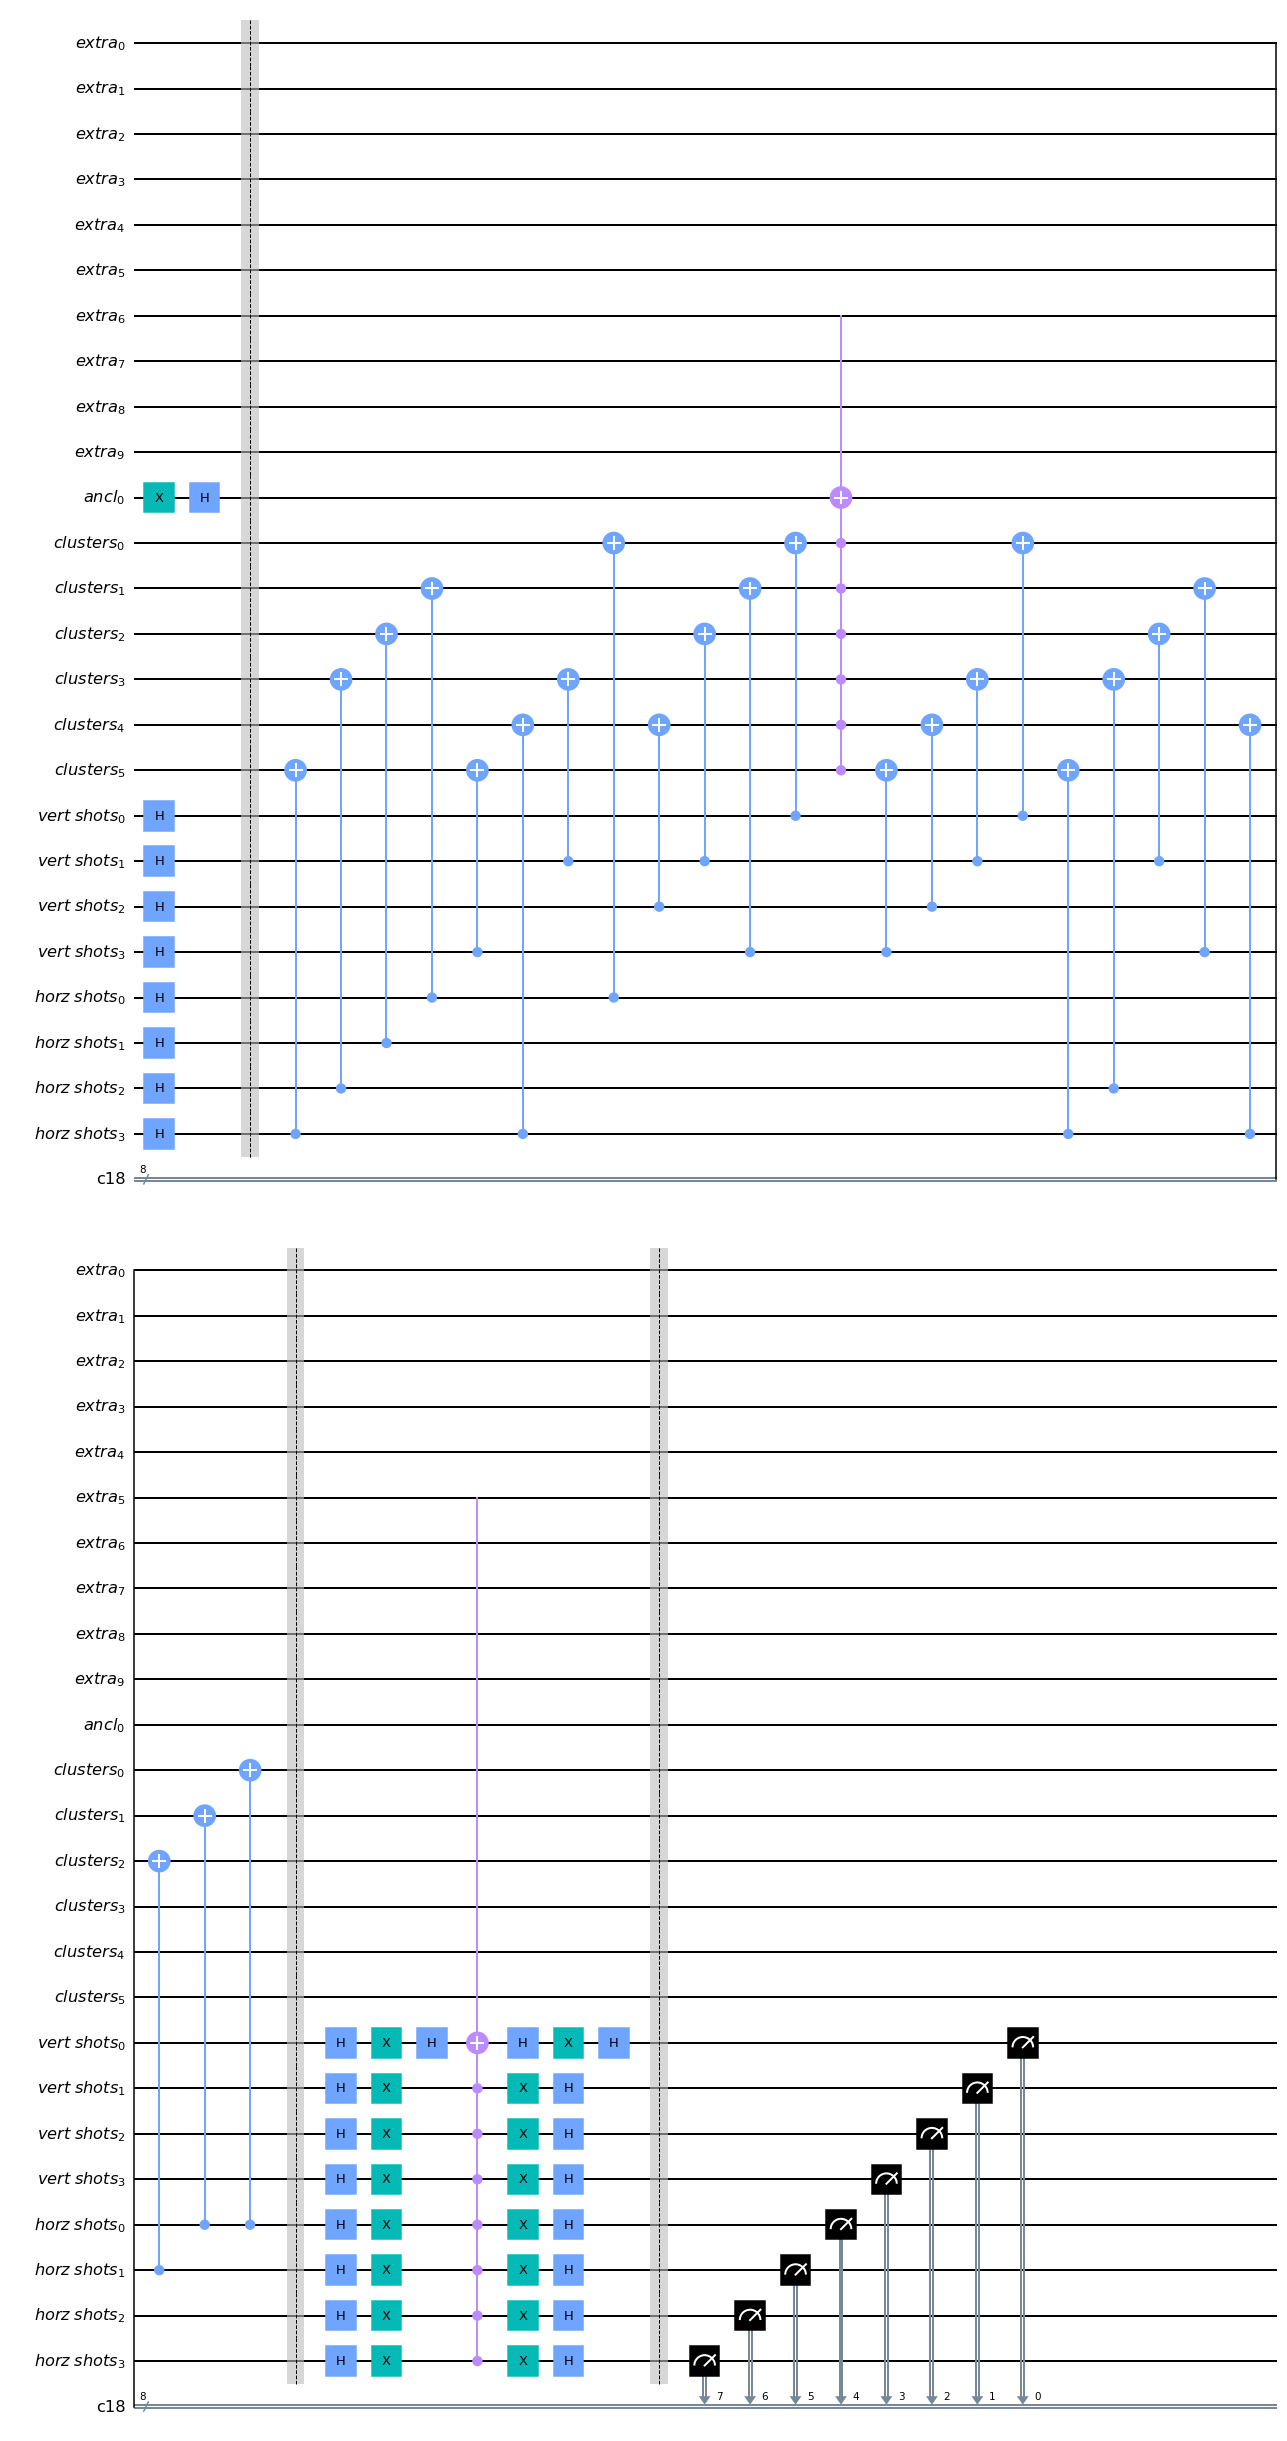

In [32]:

problem_set = [
    [["0", "2"], ["1", "0"], ["1", "2"], ["1", "3"], ["2", "0"], ["3", "3"]],
    [["0", "0"], ["0", "1"], ["1", "2"], ["2", "2"], ["3", "0"], ["3", "3"]],
    [["0", "0"], ["1", "1"], ["1", "3"], ["2", "0"], ["3", "2"], ["3", "3"]],
    [["0", "0"], ["0", "1"], ["1", "1"], ["1", "3"], ["3", "2"], ["3", "3"]],
    [["0", "2"], ["1", "0"], ["1", "3"], ["2", "0"], ["3", "2"], ["3", "3"]],
    [["1", "1"], ["1", "2"], ["2", "0"], ["2", "1"], ["3", "1"], ["3", "3"]],
    [["0", "2"], ["0", "3"], ["1", "2"], ["2", "0"], ["2", "1"], ["3", "3"]],
    [["0", "0"], ["0", "3"], ["1", "2"], ["2", "2"], ["2", "3"], ["3", "0"]],
    [["0", "3"], ["1", "1"], ["1", "2"], ["2", "0"], ["2", "1"], ["3", "3"]],
    [["0", "0"], ["0", "1"], ["1", "3"], ["2", "1"], ["2", "3"], ["3", "0"]],
    [["0", "1"], ["0", "3"], ["1", "2"], ["1", "3"], ["2", "0"], ["3", "2"]],
    [["0", "0"], ["1", "3"], ["2", "0"], ["2", "1"], ["2", "3"], ["3", "1"]],
    [["0", "1"], ["0", "2"], ["1", "0"], ["1", "2"], ["2", "2"], ["2", "3"]],
    [["0", "3"], ["1", "0"], ["1", "3"], ["2", "1"], ["2", "2"], ["3", "0"]],
    [["0", "2"], ["0", "3"], ["1", "2"], ["2", "3"], ["3", "0"], ["3", "1"]],
    [["0", "1"], ["1", "0"], ["1", "2"], ["2", "2"], ["3", "0"], ["3", "1"]],
]


def convert_problem_set_to_binary(ps: list):

    ps_binary = list()

    for row in ps:
        row_binary = ["0" for n in range(16)]
        for pair in row:
            # Convert pair to binary location:
            location = int(pair[0]) * 4 + int(pair[1])
            row_binary[location] = "1"

        row_binary = "".join(row_binary)
        ps_binary.append(row_binary)

    return ps_binary


def data_loader(qc, qr_data, problem):
    for i, bit in enumerate(problem):
        if bit == "1":
            qc.x(qr_data[i])

    return qc


def oracle(qc, qr_shot_h, qr_shot_v, qr_clustr, qr_anclla, qr_extra, problem):

    # Design question: How does cluster i relate to shot y?
    
    for i, pair in enumerate(problem):
        horz_num = int(pair[0])
        vert_num = int(pair[1])
        
        # Connect shot with cluster:
        qc.cx(qr_shot_h[horz_num],qr_clustr[i])
        qc.cx(qr_shot_v[vert_num],qr_clustr[i])

    qc.mct(qr_clustr, qr_anclla, qr_extra, mode="v-chain")

    # Uncompute
    for i, pair in enumerate(problem):
        horz_num = int(pair[0])
        vert_num = int(pair[1])
        
        # Connect shot with cluster:
        qc.cx(qr_shot_v[vert_num],qr_clustr[i])
        qc.cx(qr_shot_h[horz_num],qr_clustr[i])
        
    qc.barrier()
    
    return qc

def diffusion(qc, qubits, qr_extr):
    qc.h(qubits)
    qc.x(qubits)
    qc.h(qubits[-1])
    qc.mct(qubits[:-1], qubits[-1], qr_extr, mode="v-chain")
    qc.h(qubits[-1])
    qc.x(qubits)
    qc.h(qubits)
    
    qc.barrier()

    return qc


def week3_ans_func(problem_set):
    # Build your quantum circuit here
    # In addition, please make it a function that can solve the problem even with different inputs (problem_set). We do validation with different inputs.

    #problem = convert_problem_set_to_binary(problem_set)[1]
    problem = problem_set[1]
    
    qr_shot_h = QuantumRegister(4, name="horz shots")
    qr_shot_v = QuantumRegister(4, name="vert shots")
    qr_clustr = QuantumRegister(6, name="clusters")
    qr_anclla = QuantumRegister(1, name="ancl")
    qr_extra = QuantumRegister(10, name="extra")

    cr = ClassicalRegister(8)
    cr_test = ClassicalRegister(6)

    qc = QuantumCircuit(qr_shot_h, qr_shot_v, qr_clustr, qr_anclla, qr_extra, cr)

    # Set cluster status to 0
    # No code required

    # Prepare ancilla
    qc.x(qr_anclla)
    qc.h(qr_anclla)

    # Put solution into superposition
    qc.h(qr_shot_h[:] + qr_shot_v[:])

    qc.barrier()
    
    # Code for Grover's algorithm with iterations = 1 will be as follows.
    for i in range(1):
        oracle(qc, qr_shot_h, qr_shot_v, qr_clustr, qr_anclla, qr_extra, problem)
        diffusion(qc, qr_shot_h[:] + qr_shot_v[:], qr_extra)

    qc.measure(qr_shot_h[:] + qr_shot_v[:], cr)
    qc = qc.reverse_bits()

    return qc

qc = week3_ans_func(problem_set)
qc.draw(output="mpl")
# New idea: 6 bits for state, 8 bits for shots, problem logic is programmed into oracle? Main question: how to scale?

In [33]:

backend = Aer.get_backend("qasm_simulator")
job = execute(
    qc,
    backend=backend,
    shots=10000,
    seed_simulator=12345,
    #backend_options={"fusion_enable": True},
)
result = job.result()
count = result.get_counts()


In [34]:
# N largest values in dictionary 
# Using nlargest
N = 10
res = nlargest(N, count, key = count.get)
print(count)  
# print("The top N value pairs are  " + str(res))   
print(f"Expected solution: 10010010: {count['10010010']} counts")
print(f"Expected solution: 01001001: {count['01001001']} counts")

 
    

{'00000000': 30, '00000001': 26, '00010000': 23, '00010001': 36, '00010010': 39, '00010011': 35, '00010100': 30, '00010101': 33, '00010110': 30, '00010111': 30, '00011000': 38, '00011001': 29, '00011010': 37, '00011011': 33, '00011100': 39, '00011101': 30, '00011110': 36, '00011111': 41, '00000010': 37, '00100000': 45, '00100001': 23, '00100010': 30, '00100011': 33, '00100100': 35, '00100101': 38, '00100110': 28, '00100111': 30, '00101000': 33, '00101001': 36, '00101010': 28, '00101011': 44, '00101100': 25, '00101101': 43, '00101110': 37, '00101111': 37, '00000011': 47, '00110000': 40, '00110001': 31, '00110010': 39, '00110011': 40, '00110100': 35, '00110101': 36, '00110110': 44, '00110111': 35, '00111000': 34, '00111001': 26, '00111010': 29, '00111011': 28, '00111100': 31, '00111101': 37, '00111110': 37, '00111111': 28, '00000100': 21, '01000000': 29, '01000001': 30, '01000010': 27, '01000011': 35, '01000100': 36, '01000101': 33, '01000110': 41, '01000111': 31, '01001000': 47, '010010

In [36]:
problem = problem_set[1]
for pair in problem:
    print(pair[0])

['0', '0']
['0', '1']
['1', '2']
['2', '2']
['3', '0']
['3', '3']


In [9]:
np.pi*np.sqrt(2**8)/4

12.566370614359172